In [1]:
!pip install imblearn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import datacompy
import os, sys
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn import tree
from sklearn.tree import plot_tree


# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#methods
from imblearn.under_sampling import ClusterCentroids
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

w petli bedzie wykonywala sie np decision tree, ale kazda iteracja bedzie usunieciem danego wiersza i sprawdzeniem jak to wplywa na wynik

### DATA


In [5]:
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderlinesmote_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\Test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\Test\\y_test.csv")

In [6]:
#sum synthetic data
sum_syn_data = pd.concat([smote_data, borderline_data], axis=0)
sum_syn_data = pd.concat([sum_syn_data, GAN_data], axis=0)
sum_syn_data = sum_syn_data.reset_index(drop=True)

X_train_syn = sum_syn_data.drop(columns=["target", "source"])
y_train_syn = sum_syn_data['target']

# sum all data
sum_data = pd.concat([original_data, sum_syn_data], axis=0)
sum_data = sum_data.reset_index(drop=True)
sum_data = sum_data.drop(columns=["Unnamed: 0"])

#X and y 
X_train_sum = sum_data.drop(columns=["target", "source"])
y_train_sum = sum_data['target']

In [7]:
con = original_data['target'].value_counts()
print("Przed", con)
print(original_data.shape)
print(sum_syn_data.shape)

print(sum_data.shape)

print(X_train_sum.head())

Przed target
0    163
1     53
Name: count, dtype: int64
(216, 13)
(330, 12)
(546, 12)
   is_private  is_failure  is_root  is_valid  not_valid_count  ip_failure  \
0           1           1        0         1                0           4   
1           1           0        0         1                0           0   
2           1           1        1         1                0           4   
3           1           1        0         1                0           3   
4           1           1        0         1                0           1   

   ip_success  no_failure  first   td  
0          14           6      0    4  
1           1           0      0   23  
2           2           6      0  623  
3           0           2      0    7  
4           1           2      0   58  


### ClusterCentroids

In [8]:
file_path2 = "D:\\ml\\undersampling_data\\data\\ssh\\CC_data.csv"

cluscentr = ClusterCentroids(voting="auto", sampling_strategy="majority", random_state=42)

X_res_CC, y_res_CC = cluscentr.fit_resample(X_train_sum, y_train_sum)
print(y_res_CC.value_counts())

CC_data = pd.concat([X_res_CC, y_res_CC], axis=1)
if not os.path.exists(file_path2):
    CC_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


target
0    163
1    163
Name: count, dtype: int64
Plik istnieje pod ścieżką: D:\ml\undersampling_data\data\ssh\CC_data.csv


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Differential_evolution => Himmelblau fun

is_private


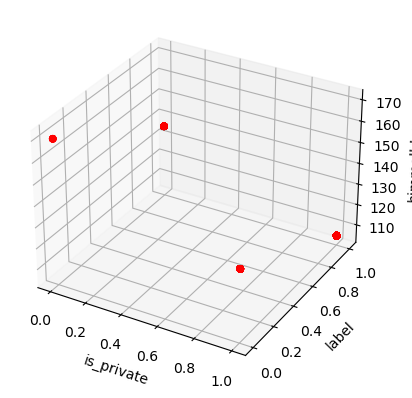

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [54]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

features_list = X_train.columns.to_list()

for column in features_list:
    print(column)
    out_himmelblau = himmelblau(X_train[column], y_train)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train[column], y_train, out_himmelblau, c='r', marker='o')
    ax.set_xlabel(column)
    ax.set_ylabel('label')
    ax.set_zlabel('himmelblau')
    plt.show()
    
    bounds_cal = [(X_train[column].min(), X_train[column].max())]
    
    result = differential_evolution(func=himmelblau, bounds=bounds_cal, args=(y_train))
    
    print('Optymalne wartości zmiennych:', result.x)
    print('Minimalna wartość funkcji:', result.fun)


### KMeans

In [151]:
Kmeans = KMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=0)

df = pd.DataFrame(X_train)
Kmeans.fit(df)
print(f'Kmeans labels: {Kmeans.labels_}')
df = pd.DataFrame(sum_data)

Kmeans labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [152]:
df["cluster"] = Kmeans.predict(X_train)
print(df.head())

print(df["cluster"].value_counts())
#df.groupby("target", "cluster").agg({"target": "count"})

centroids = Kmeans.cluster_centers_

print("Centroidy klastrów:")
for i, centroid in enumerate(centroids):
    print(f"Klaster {i}: {centroid}")

   is_private  is_failure  is_root  is_valid  not_valid_count  ip_failure  \
0           1           1        0         1                0           4   
1           1           0        0         1                0           0   
2           1           1        1         1                0           4   
3           1           1        0         1                0           3   
4           1           1        0         1                0           1   

   ip_success  no_failure  first   td  target    source  cluster  
0          14           6      0    4       0  original        0  
1           1           0      0   23       0  original        0  
2           2           6      0  623       0  original        0  
3           0           2      0    7       0  original        0  
4           1           2      0   58       0  original        0  
cluster
0    545
1      1
Name: count, dtype: int64
Centroidy klastrów:
Klaster 0: [7.94495413e-01 8.97247706e-01 1.59633028e-01 4.8623

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to ha

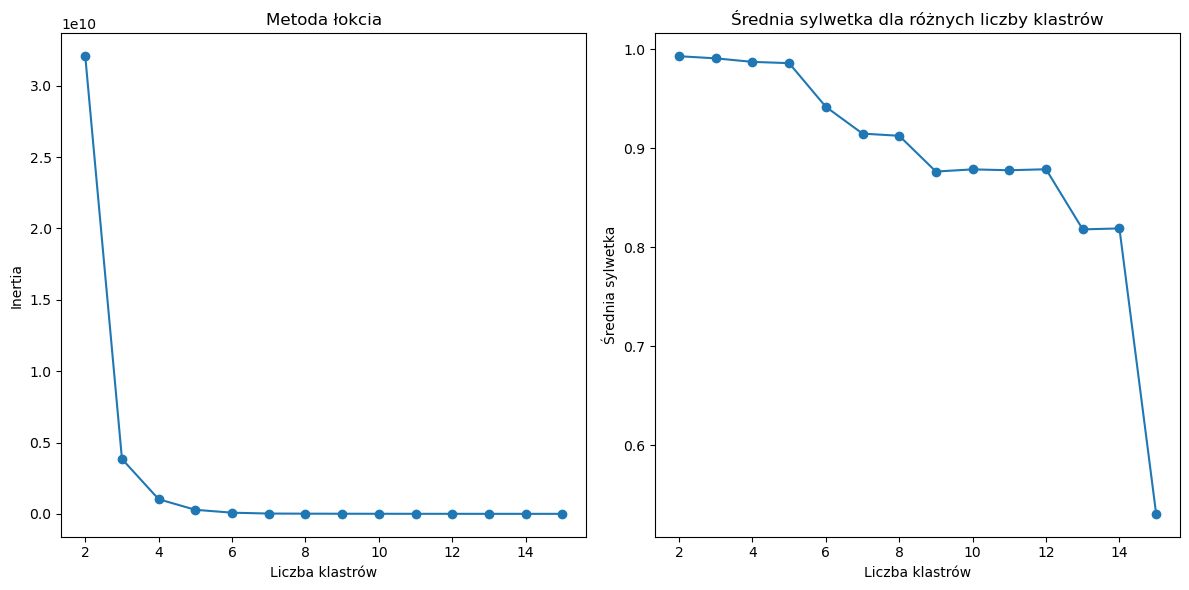

In [150]:
# Metoda łokcia
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 16)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

# Wykres metody łokcia
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Liczba klastrów')
plt.ylabel('Inertia')
plt.title('Metoda łokcia')

# Wykres średniej sylwetki
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Liczba klastrów')
plt.ylabel('Średnia sylwetka')
plt.title('Średnia sylwetka dla różnych liczby klastrów')

plt.tight_layout()
plt.show()

### IsolationForest

zle dane -> powinienem dodac dane tylko syntetyczne

In [39]:
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f'Sum up original: {num_syn}')

num_sum = sum_data["target"].value_counts()
#print(f'Sum up original: {num_sum}')
if num_sum[1]>0:
    over_samples = abs(num_sum[0]-num_sum[1])
#target_percentage = round((over_samples/num_syn)*100,2)
#reduce_precentage = 100 - target_percentage
target = num_syn - over_samples
target = int(target)
print(f'Under samples: {target}')
#print(f'Percentage of data: {target_percentage}')

df = syn_data.copy()
df = df.drop(columns=["target"])

def iso_forest(df, perc):
    iso_forest = IsolationForest(n_estimators=200, contamination=perc, random_state=0, n_jobs=1)
    iso_forest.fit(df)
    df['anomaly'] = iso_forest.predict(df)
    df = df[df['anomaly'] == 1].copy()
    return df

def reduce_data(df, target):
    
    """ if reduce_precentage > 0.5:
        perc = 0.5
        df = iso_forest(df, perc)
        current_percentage = (current_percentage - reduce_precentage)
        print(f'Current percentage: {current_percentage}%') """
    
    #target_percentage = 1 - target_percentage
    
    current = num_syn
    iter = 0
    while current > target:
        if (target*2) <= current:
            perc = 0.5
            df = iso_forest(df, perc)
            current = current/2
            print(f'Current num of samples: {current}')
            print(f"{iter}")
            iter += 1
            
        else:
            temp = current-target
            perc = 1 - (target/current)
            df = iso_forest(df, perc)
            current = current - temp
            print(f'Current num of samples: {current}')
            print(f"{iter}")
            iter += 1
        
        # od danych df usun dane odstajace
        #df = df[df['anomaly'] == 1].copy()
        #current_percentage *= (1 - perc)
        #print(f'Current percentage: {current_percentage}%')
        
        # Zachowaj tylko normalne dane (anomaly == 1)
        #df = df[df['anomaly'] == 1].copy()
        #current_percentage *= perc
        #print(f'Current percentage: {current_percentage}%')
    
    return df

print(f'Before: {df.shape}')
reduced_df = reduce_data(df, target)
print(f'After: {reduced_df.shape}')

indexes = reduced_df.index.intersection(sum_syn_data.index)
reduced_IF = sum_syn_data.loc[indexes]

file_path = "D:\\ml\\undersampling_data\\data\\ssh\\IF_data.csv"
if not os.path.exists(file_path):
    reduced_IF.to_csv(file_path, index=False)

Sum up original: 330
Under samples: 110
Before: (330, 10)
Current num of samples: 165.0
0
Current num of samples: 110.0
1
After: (110, 11)


anomaly
 1    197
-1    133
Name: count, dtype: int64


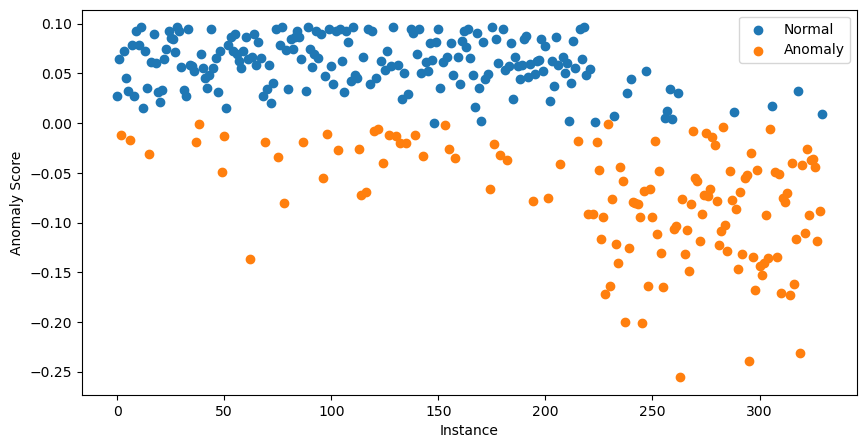

   is_private  is_failure  is_root  is_valid  not_valid_count  ip_failure  \
0           1           1        0         0                9          40   
1           1           1        0         0               19          19   
3           1           1        0         0               17          17   
4           0           1        0         0                1           4   
5           1           1        0         0                8          39   

   ip_success  no_failure  first  td  target  anomaly_score  anomaly  
0           0          40      0   3       1       0.027715        1  
1           0          19      0   4       1       0.064912        1  
3           0          17      0   4       1       0.072156        1  
4           0          11      0   9       1       0.045381        1  
5           0          39      0   3       1       0.032802        1  
Normal
target
1    197
Name: count, dtype: int64
Anomaly
target
1    133
Name: count, dtype: int64


In [72]:
iso_forest = IsolationForest(n_estimators=200, contamination=0.403, random_state=0, n_jobs=1)
#0.403
iso_forest.fit(X_train_syn)

y_IF = iso_forest.predict(X_train_syn)

data2 = syn_data.loc[X_train_syn.index].copy()
data2['anomaly_score'] = iso_forest.decision_function(X_train_syn)
data2['anomaly'] = iso_forest.predict(X_train_syn)

print(data2['anomaly'].value_counts())

# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data2[data2['anomaly'] == 1]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data2[data2['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

print(normal.head())

#save data
file_path = "D:\\ml\\undersampling_data\\data\\ssh\\IF_data.csv"
if not os.path.exists(file_path):
    normal.to_csv(file_path, index=False)

#distribution normal and anomaly
print("Normal")
print(normal['target'].value_counts())
print("Anomaly")
print(anomalies['target'].value_counts())

### LocalOutlierFactor

In [75]:
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.403, novelty=True, n_jobs=1)

LOF.fit(X_train_syn)

y_LOF = LOF.predict(X_train_syn)
print(y_LOF)

[ 1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1
  1  1  1 -1  1 -1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
 -1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1 -1
 -1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1 -1  1
  1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1
 -1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1
 -1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1  1

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
